In [ ]:
#MIT License

#Copyright (c) [2021] [Oliver Böhme]

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

In [2]:
#Problem Framing:

#There are many ways to harness and explore a given dataset.
#In this paper, we will use the data to explore a very specific question; that is:
#Given recent number of problems and influencal factors what is the expected number of problems for the upcoming time steps until we reach SOP?

#This requires that a predictive model forecasts the total number of errors for each week over the residual weeks.

#Technically, this framing of the problem is referred to as a multivariate multi-step time series forecasting problem, given the multiple forecast steps. 
#A model, that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.
#A model of this type could be helpful within the <Anwendungsfall>
#It could also be helpful on the <Anwendungsfall>.

#Data Description
#Non-stationarity is when the statistical properties of a series, e.g the mean, variance, and covariance (or the process generating the series) changes over time. 
#Non-stationary series are typically difficult to model and forecast and are therefore required to be made stationary to obtain meaningful results as many statistical tools and processes require stationarity. 
#A proven method of stationarizing a non-stationary series is through the use of differencing.

#Credits
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [3]:
#Import Libraries:

import pandas as pd
from pandas import read_csv
from pandas import to_numeric

import numpy as np
from numpy import split
from numpy import array
from numpy import nan
from numpy import isnan

import csv
import math
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, GRU, Flatten, RepeatVector, TimeDistributed, Bidirectional

import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


Shape of the Dataset_raw:  (49920, 11)


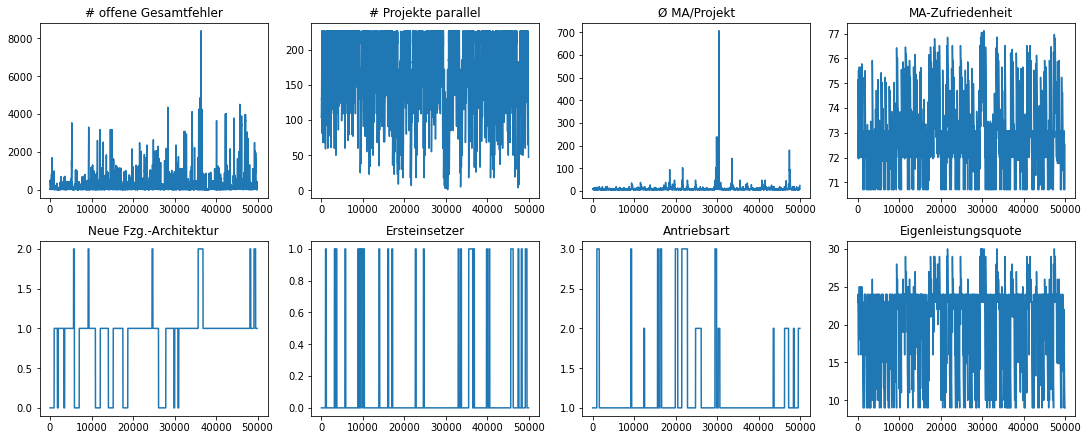

In [4]:
#Import DataSet:

data_raw = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/DataSet_Prediction_multivariat_preprocessed_feature selected_v04e_20211003_OB.xlsm',0)
print('Shape of the Dataset_raw: ',data_raw.shape)
data_raw.head()

#Drop unneccessary Columns:
dataset = data_raw.iloc[:,3:11]

#Plot the Data
figure, axis = plt.subplots(2,4, figsize=(15,6), constrained_layout=True)

axis[0,0].plot(dataset.iloc[:,0:1])
axis[0,0].set_title("# offene Gesamtfehler")

axis[0,1].plot(dataset.iloc[:,1:2])
axis[0,1].set_title("# Projekte parallel")

axis[0,2].plot(dataset.iloc[:,2:3])
axis[0,2].set_title("Ø MA/Projekt")

axis[0,3].plot(dataset.iloc[:,3:4])
axis[0,3].set_title("MA-Zufriedenheit")

axis[1,0].plot(dataset.iloc[:,4:5])
axis[1,0].set_title("Neue Fzg.-Architektur")

axis[1,1].plot(dataset.iloc[:,5:6])
axis[1,1].set_title("Ersteinsetzer")

axis[1,2].plot(dataset.iloc[:,6:7])
axis[1,2].set_title("Antriebsart")

axis[1,3].plot(dataset.iloc[:,7:8])
axis[1,3].set_title("Eigenleistungsquote")

plt.show()

In [ ]:
#Plot offene Gesamtfehler
projects2visualize = dataset
time = np.arange(len(projects2visualize))

plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Number of errors")
    
for i in range(0,256):
    plt.plot(time[0:195], projects2visualize.iloc[i*195:((i*195)+195),0:1])

plt.show()


In [5]:
#Choose Feature Set:
dataset = data_raw.iloc[:,3:5]
print('Shape of the Dataset: ',dataset.shape)
print(dataset.head())


Shape of the Dataset:  (49920, 2)
   Anzahl offene Gesamtfehler  Anzahl parallel entwickelter Projekte
0                          21                                    104
1                          16                                    104
2                          12                                    104
3                          12                                    106
4                          12                                    109


In [6]:
#Define Length of Input/Output Sequences:

n_input = 135
n_out = 60


In [7]:
#Split multivariate DataSet into Train/ Test Sets:

#Normalize Dataset
#scaler = MinMaxScaler()
#dataset_scaled = scaler.fit_transform(dataset)


#Split into Length of Car Projects (195 time stamps)
split_time = math.ceil(0.5*len(dataset)/195)*195 #Ratio: 70/30 #Define Ratio Train/Test-Split
train, test = dataset[:split_time], dataset[split_time:]
#train, test = dataset_scaled[:split_time], dataset_scaled[split_time:] #Normalize Data
    
#Restructure into Windows of Length of one Verhicle Project
train = array(split(train, len(train)/195))
test = array(split(test, len(test)/195))


#Testing/Bugfixing
print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)


Train Shape:  (128, 195, 2)
Test Shape:  (128, 195, 2)


In [8]:
#Data Preparation: Convert Train-DataSet into Inputs and Outputs:

#Flatten Data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

X, y = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_input = data[in_start:in_end, 0]
        X_input = X_input.reshape((len(X_input), 1))
        X.append(data[in_start:in_end, :])
        y.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

#Debug
print(array(X).shape)
print(array(y).shape)
#print(array(X)[0:330])
#print(array(y)[0:330])

(128, 135, 2)
(128, 60)


In [9]:
#Data Preparation: Convert Test-DataSet into Inputs and Outputs:

#Flatten Data
data = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))

X_test, y_test = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_test_input = data[in_start:in_end, 0]
        X_test_input = X_test_input.reshape((len(X_test_input), 1))
        X_test.append(data[in_start:in_end, :])
        y_test.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

X_test = array(X_test)
y_test = array(y_test)
#Debug
#print(array(X_test).shape)
#print(array(y_test).shape)
#print(array(X_test)[0:330])
#print(array(y_test)[0:330])

In [10]:
#Define and train the Model:

#Prepare Data
train_x, train_y = array(X), array(y)

#Define Parameters
verbose, epochs, batch_size = 1, 2000, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
#print("n_timesteps, n_features, n_outputs: ",n_timesteps, n_features, n_outputs)

#Reshape Output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1)) 

#Define Model
model = Sequential()

model.add(LSTM(512, activation='tanh', input_shape=(n_timesteps, n_features)))

model.add(RepeatVector(n_out)) #The Internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence

model.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True))) #We then define the decoder as an LSTM hidden layer with 200 units. Importantly, the decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the seven days, representing the basis for what to predict for each day in the output sequence.
    
model.add(TimeDistributed(Dense(256, activation='relu'))) #We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer.
    
model.add(TimeDistributed(Dense(1))) #Importantly, the output layer predicts a single step in the output sequence, not all seven days at a time. The network therefore outputs a three-dimensional vector with the same structure as the input, with the dimensions [samples, timesteps, features]
    
model.compile(loss='mae', optimizer='adam')

#Fit the Model
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/2000
8/8 [==============================] - 7s 594ms/step - loss: 177.8960
Epoch 2/2000
8/8 [==============================] - 5s 585ms/step - loss: 160.9068
Epoch 3/2000
8/8 [==============================] - 5s 590ms/step - loss: 154.7600
Epoch 4/2000
8/8 [==============================] - 5s 588ms/step - loss: 151.0877
Epoch 5/2000
8/8 [==============================] - 5s 599ms/step - loss: 146.5136
Epoch 6/2000
8/8 [==============================] - 5s 601ms/step - loss: 139.2193
Epoch 7/2000
3/8 [==========>...................] - ETA: 3s - loss: 119.5686

KeyboardInterrupt: 

Predict the last 60 Values of the last Vehicle Development Project:



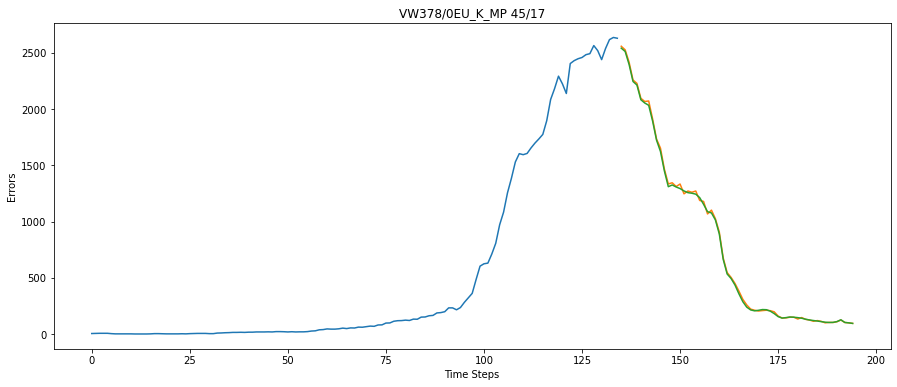

In [10]:
#Make Forecasts:
print("Predict the last 60 Values of the last Vehicle Development Project:\n")
#Flatten Data
history = [x for x in train] #Note: History = train
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
y = train_y.reshape((train_y.shape[0]*train_y.shape[1], train_y.shape[2]))[-n_out:]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("VW378/0EU_K_MP 45/17")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], y[:])
plt.plot(time[135:195], yhat[:])

plt.show()


GRU: [754.961] 262.0, 269.7, 281.3, 302.2, 306.0, 304.8, 310.0, 312.5, 295.5, 281.3, 276.1, 274.5, 270.4, 265.2, 261.0, 265.2, 282.3, 291.9, 302.5, 320.4, 326.7, 330.7, 335.6, 344.1, 360.0, 369.4, 377.5, 380.5, 389.9, 395.7, 399.8, 402.9, 399.9, 402.2, 400.0, 400.4, 393.1, 391.0, 390.9, 386.5, 383.4, 374.3, 344.2, 294.3, 287.0, 277.0, 263.8, 250.4, 253.4, 253.2, 250.7, 244.2, 230.0, 218.8, 219.8, 220.2, 211.2, 203.4, 192.6, 203.9


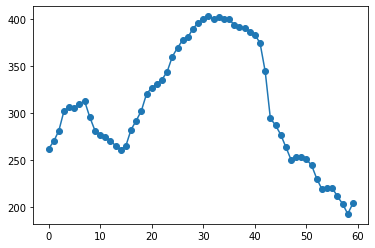

Overall MAE:  754.9606363910638


In [11]:
#Evaluate the Model:

predictions = list()

#print("Test Shape: ",test.shape)
for i in range(test.shape[0]):
    #Predict the Output Sequence
    history = test[i:i+1,:,:] #for each Car Project
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        
    #Retrieve last Observations for Input Data
    input_x = data[-n_input-n_out:-n_out, :]
    
    #Reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
    
    #Forecast
    yhat = model.predict(input_x, verbose=0)
    
    #We only want the Vector Forecast
    yhat_sequence = yhat[0]
        
    #Store the Predictions
    predictions.append(yhat_sequence)
        
#print("Predictions Shape: ",array(predictions).shape)

#Evaluate predicted Time Steps for each Car Project
predictions = array(predictions)
scores = list()
actual, predicted = array(y_test), array(predictions)

#print(array(actual).shape)
#print(array(predicted).shape)

for i in range(predicted.shape[1]):
    #Calculate MSE
    #mse = mean_squared_error(actual[:, i], predicted[:, i])
    
    #Calculate RMSE
    #rmse = sqrt(mse)
    
    #Calculate MAE
    mae = mean_absolute_error(actual[:, i], predicted[:, i])
    #print("Step: ",i)
    #print("y", actual[:,i])
    #print("yhat", predicted[:,i])
    #print("MAE: ", mae)
    
    #Store the Scores
    #scores.append(rmse)
    scores.append(mae)

#Calculate overall MAE (alternative: RMSE)
s = 0
    
for row in range(predicted.shape[0]):
    for col in range(predicted.shape[1]):
        s += (actual[row, col] - predicted[row, col])**2
    
score = sqrt(s / (actual.shape[0] * actual.shape[1]))

#Visualize MAE
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % ('GRU', score, s_scores))

pyplot.plot(scores, marker='o', label='lstm')
pyplot.show()


print("Overall MAE: ",score)

In [12]:
###########################################################################################################################
########################################## Visualization of Predicted Data ################################################
###########################################################################################################################

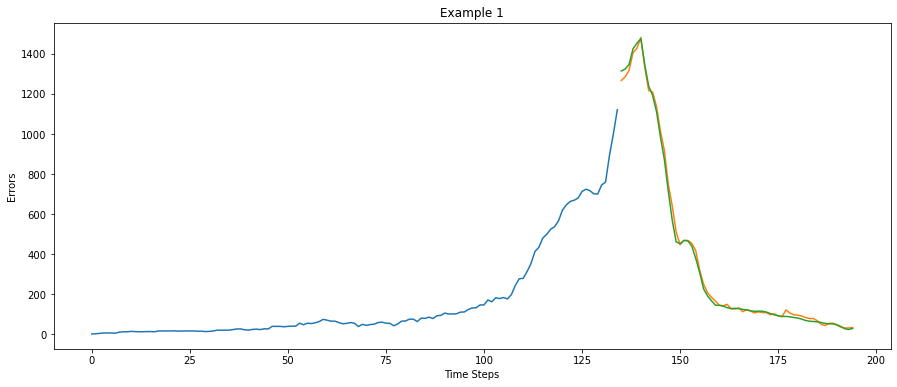

In [13]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 1
example=1
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1], predicted.shape[2]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 1")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

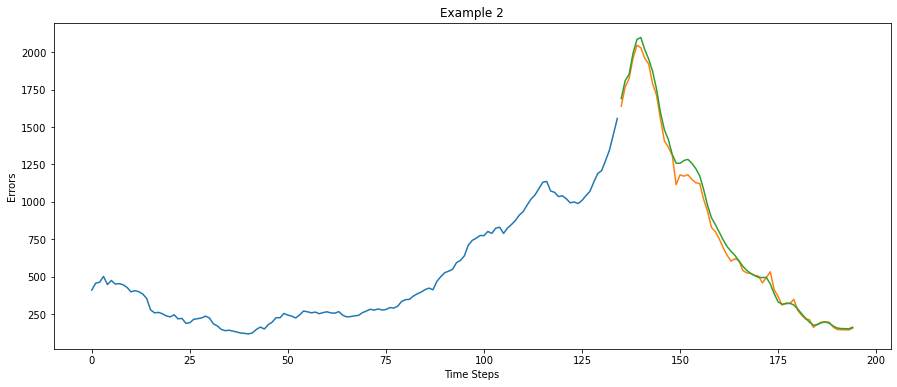

In [14]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 2
example=2
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1], predicted.shape[2]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 2")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

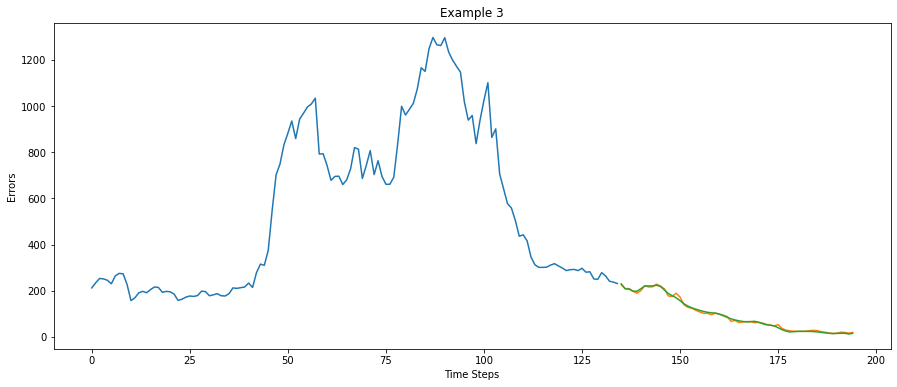

In [15]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 3
example=30
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1], predicted.shape[2]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 3")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

In [16]:
###########################################################################################################################
########################################## Verifikation am realen Beispiel ################################################
###########################################################################################################################

Predict the last 60 Values of the test vehicle project:



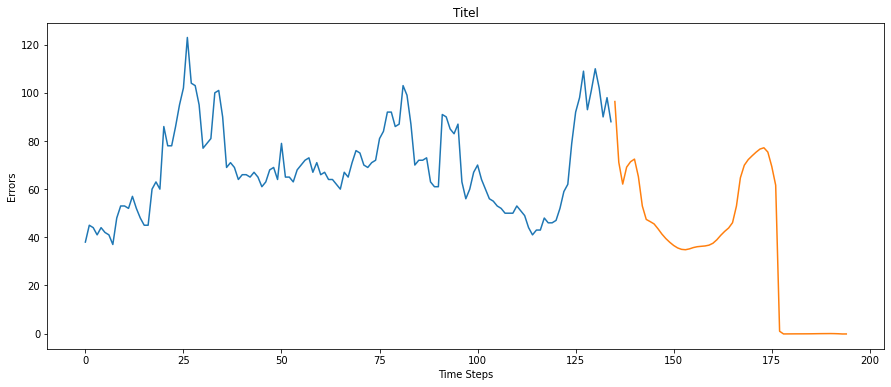

In [17]:
#Import Validation Data
validation_data = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/X_Test_Prediction_multivariat_preprocessed_v03e_20211003_OB.xlsm',0)
#print('Shape des RAW-Datasets: ',validation_data.shape)
validation_data.head()

#Drop unneccessary Columns:
validation_data = validation_data.iloc[:,3:5]
#print('Shape of the Dataset: ',validation_data.shape)
#print(validation_data.head())

#Normalize Input Data
#scaler = MinMaxScaler()
#validation_data_scaled = scaler.fit_transform(validation_data)

#Set nth sample to show
n=1

#Manuelle Definition Array erstes reales Verifikationsbeispiel x1 
#x1 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x1 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x1 = array(split(x1, len(x1)/195))
#print("Shape x1: \n",x1.shape,"\n")
#print("x1: \n",x1)

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x1 #Note: History = x1
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()

Predict the last 60 Values of the test vehicle project:



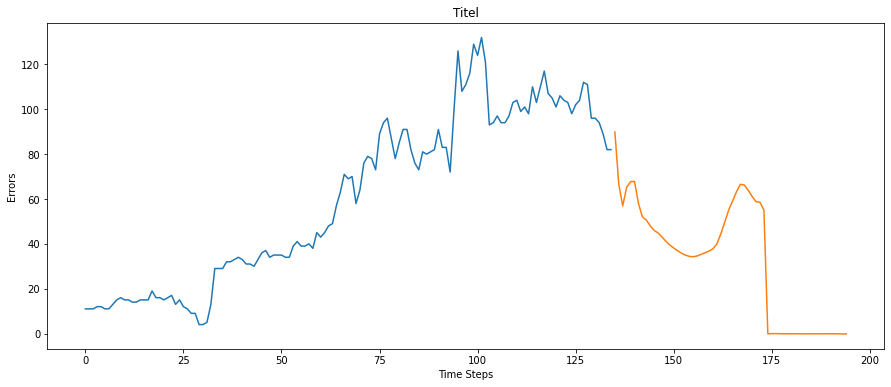

In [18]:
#Set nth sample
n=2

#Manuelle Definition Array erstes reales Verifikationsbeispiel x2
#x2 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x2 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x2 = array(split(x2, len(x2)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x2
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



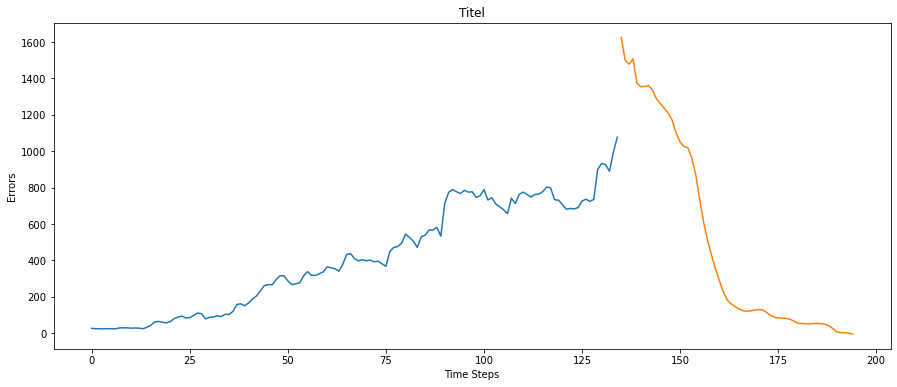

In [19]:
#Set nth sample
n=3

#Manuelle Definition Array erstes reales Verifikationsbeispiel x3 
#x3 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x3 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x3 = array(split(x3, len(x3)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x3
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



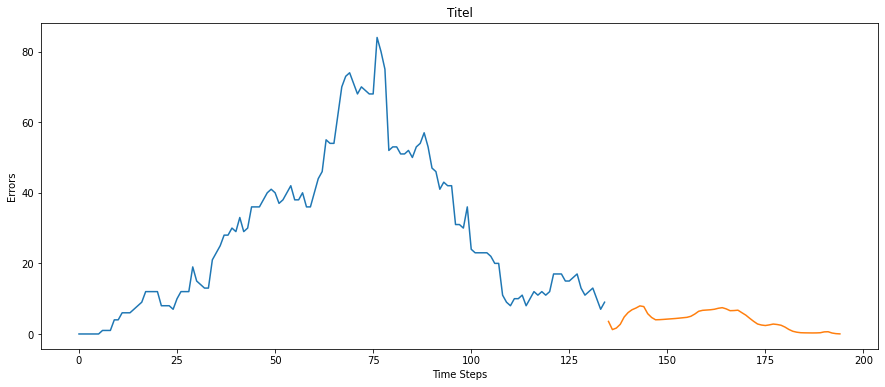

In [20]:
#Set nth sample
n=4

#Manuelle Definition Array erstes reales Verifikationsbeispiel x4
#x4 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x4 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x4 = array(split(x4, len(x4)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x4
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



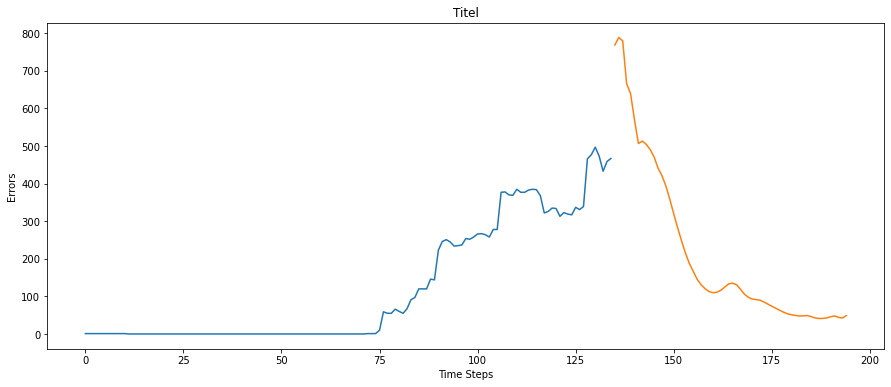

In [21]:
#Set nth sample
n=7

#Manuelle Definition Array erstes reales Verifikationsbeispiel x5
#x4 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x5 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x5 = array(split(x5, len(x5)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x5
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()
